# Yield Curve Construction 

Constructing STIBOR and Swedish OIS continuous yield curves with interpolation and in-exact optimzation models. The construction of the yield curves requires market quotes of Swedish FRA, IRS, OIS instruments in addition to the quoted short-end of the STIBOR curve.  

### The STIBOR spot curve

The STIBOR zero curve is build by three different instruments. The quoted cash rate, FRN and IRS. Indicative quotes by different market makers are fetched for each instrument. There are multiple steps in this procedure. For each instrument we must derive the zero rates, as none of the instruments display that directly.

In [26]:
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

#### Part 1. The Short End

To build the short end we use the quoted STIBOR rates. These are quoted as simple interest rates. While Sweden does not have an official ON rate, the TN is approximated as an ON rate. Also, it is technically a simple forward rate, but will not be considered as such.


| Tenor | STIBOR=Q | 
| ----------- | ----------- |
| TN      | 1.6840        |
| 1W      | 1.7120        |
| 1M      | 1.6780        |
| 2M      | 1.6720        |
| 3M      | 1.7260        |
| 6M      | 2.3330        |

#

On Swedish interbank markets the day count convention for loans follow ACT/360. To convert the rates from simple rates into zero rates, we first compute the appropriate discount rate:

$$
d(T) = \frac{1}{1+rT}.
$$

An zero rate has the discount conversion:

$$
d(T) = \frac{1}{(1+r)^T}.
$$

Thus we can convert between the two, by computing the STIBOR discount rate and then transforming it into a zero rate. For thus purpose we will use the same day count convention as the original instrument.

In [7]:
stibor_ask = 1e-2 * np.array([1.6840, 1.7120, 1.6780, 1.6720, 1.7260, 2.3330])
stibor_tenor = 1/360 * np.array([1, 7, 30, 60, 90, 180])

In [17]:
def simple_to_discount(rate: np.array, tenor: np.array) -> np.array:
    return 1 / (1 + rate * tenor)

In [18]:
def discount_to_spot(discount_rate: np.array, tenor: np.array) -> np.array:
    return (1/discount_rate) ** (1/tenor) - 1

In [19]:
discount_rates = simple_to_discount(stibor_ask, stibor_tenor)
spot_rates = discount_to_spot(discount_rates, stibor_tenor)

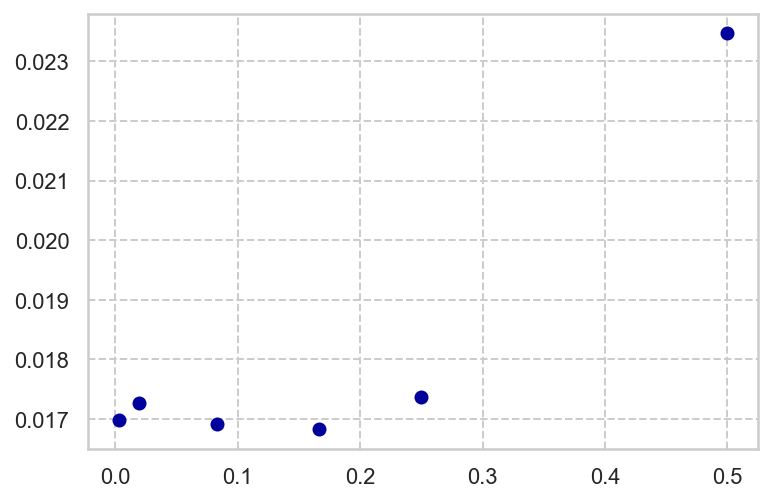

In [40]:
plt.plot(stibor_tenor, spot_rates, 'o')
plt.show()

#### Part 2. The Medium End

To buld the medium tenor part of the yield curve we must use Forward Rate Agreements (FRAs). These instruments are given indicative bid/ask quotes by market makers. The FRAs specifiy rate which can be bought or sold at some point in the future. The instruments act much like a Single Period Swap. There is an exchange between the quoted fixed rate, and the floating rate 3M STIBOR. 

By using the mid-prices one can obtain the simple forward rate between dates. For instance: 3#1 is the 3M STIBOR rate between 1 month and 4 months from now. That is, the 1 month forward 3M STIBOR rate. 

| Tenor | SEKFRA=Q bid | SEKFRA=Q ask | 
| ----------- | ----------- |----------- |
| 3#1    | 2.620       | 2.640 |
| 3#2    | 3.212       | 3.232 |
| 3#3    | 3.382       | 3.402 |
| 3#4    | 3.447       | 3.487 |
| 3#5    | 3.316       | 3.356 |
| 3#6    | 3.360       | 3.380 |
| 3#7    | 3.335       | 3.385 |
| 3#8    | 3.304       | 3.344 |
| 3#9    | 3.255       | 3.305 |
| 3#10   | 3.250       | 3.300 |
| 3#11   | 3.224       | 3.275 |
| 3#12   | 3.150       | 3.200 |

#

The calculations for extending the yield curve becomes more cumbersome. This is due to the requirement of bootstrapping. To use the first point in the FRA curve, we must know the 1M STIBOR. This continues, as we need the 2M STIBOR to use the second point of the FRA curve, etc. Also, the forward rates are simple interest rates. These must be converted into spot rates.

In [43]:
fra_bid = 1e-2 * np.array([2.620, 3.212, 3.382, 3.447, 3.316, 3.360, 3.335, 3.304, 3.255, 3.250, 3.224, 3.150])
fra_ask = 1e-2 * np.array([2.640, 3.232, 3.402, 3.487, 3.356, 3.380, 3.385, 3.344, 3.305, 3.300, 3.275, 3.200])
fra_mid = (fra_bid + fra_ask) / 2 

In [97]:
fra_mid

array([0.0263  , 0.03222 , 0.03392 , 0.03467 , 0.03336 , 0.0337  ,
       0.0336  , 0.03324 , 0.0328  , 0.03275 , 0.032495, 0.03175 ])

In [84]:
temp = ((1+0.03392*90/360) * (1 + 1.7260/100 * 90/360) - 1) / (180/360)
temp

0.025663182400000206

In [108]:
previous_months = [1.6780/100, 1.6720/100, 1.7260/100]
fra_simple_rates = []

for i in range(len(fra_mid)):

    previous_month_simple_rate = previous_months[i]
    current_frn_rate = fra_mid[i]

    previous_month_dcf = 30 * (i+1) / 360
    fra_simple_dcf = previous_month_dcf + 90/360

    fra_simple = ((1 + previous_month_simple_rate * previous_month_dcf) * (1 + current_frn_rate * 30/360) - 1 ) / fra_simple_dcf
    fra_simple_rates.append(fra_simple)

    previous_months.append(fra_simple)

# Transform into numpy array for future boradcasting.
fra_simple_rates = np.array(fra_simple_rates)
fra_tenors = np.array([(i+4)*30/360 for i in range(len(fra_simple_rates))])

In [109]:
fra_discount_rates = simple_to_discount(fra_simple_rates, fra_tenors)
fra_spot_rates = discount_to_spot(fra_discount_rates, fra_tenors)

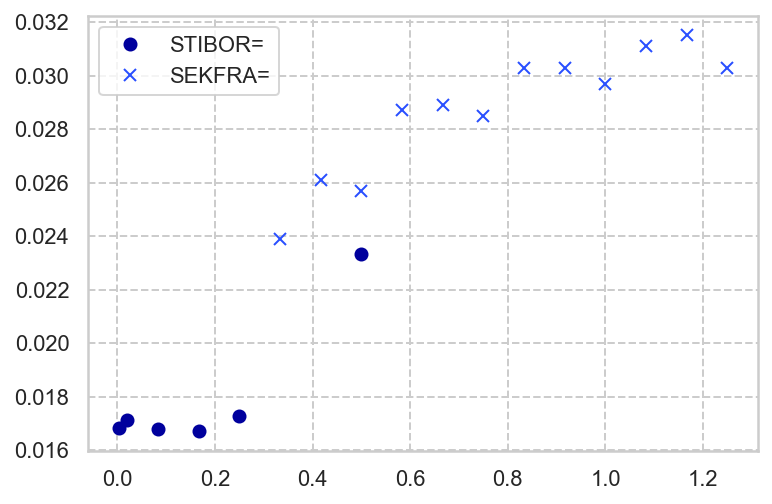

In [130]:
fra_temp = [0.0239, 0.0261, 0.0257, 0.0287, 0.0289, 0.0285, 0.0303, 0.0303, 0.0297, 0.0311, 0.0315, 0.0303]
plt.plot(stibor_tenor, stibor_ask, 'o', label="STIBOR=")
plt.plot(fra_tenors, fra_temp, 'x', label='SEKFRA=')
plt.legend()
plt.show()

In [131]:
print(fra_temp)
print(stibor_ask)

[0.0239, 0.0261, 0.0257, 0.0287, 0.0289, 0.0285, 0.0303, 0.0303, 0.0297, 0.0311, 0.0315, 0.0303]
[0.01684 0.01712 0.01678 0.01672 0.01726 0.02333]


#### Part 3. The Long End

| Tenor | SEKIRS=Q bid | SEKIRS=Q ask | 
| ----------- | ----------- |----------- |
| 1Y    | 2.8380      | 2.8580 |
| 18M   | 3.0600      | 3.0800 |
| 2Y    | 3.1420      | 3.1720 |
| 3Y    | 3.2080      | 3.2380 |
| 4Y    | 3.1980      | 3.2280 |
| 5Y    | 3.1900      | 3.2100 |
| 6Y    | 3.1500      | 3.1800 |
| 7Y    | 3.1250      | 3.1550 |
| 8Y    | 3.1030      | 3.1230 |
| 9Y    | 3.0780      | 3.0980 |
| 10Y   | 3.0520      | 3.0820 |
| 12Y   | 3.0120      | 3.0420 |
| 15Y   | 2.9580      | 2.9880 |
| 20Y   | 2.8620      | 2.8920 |
| 30Y   | 2.6820      | 2.7120 |